In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [117]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.0001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [146]:
# Get test split
# bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS']
bands = ['VIIRS']
test_batcher = batcher.Batcher(bands, country_year='nigeria-2018', bucket=False, shuffle=False, split='custom', repeat=1, batch_size=3511).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 1)


In [147]:
# Load model
experiments = ['imagery_sample_cnn_regression_NL']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [148]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
    loss=LOSS,
    optimizer=OPT,
    metrics=METRICS,
)

y_preds = trained_model.predict(x_true)
print(y_preds)

2023-02-23 14:13:56.883227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 6s 263ms/step
[[-7.66510248e-01]
 [-2.08391786e+00]
 [-1.44107091e+00]
 [ 2.77571771e-02]
 [ 8.33873630e-01]
 [-2.67291808e+00]
 [-1.34719837e+00]
 [-2.73253560e+00]
 [-2.91204953e+00]
 [-4.61826324e-01]
 [-2.67529035e+00]
 [ 4.86676102e+01]
 [-8.12448859e-01]
 [ 2.25047007e-01]
 [-1.13367617e+00]
 [-1.03536236e+00]
 [-2.18683696e+00]
 [-2.85845566e+00]
 [-2.92490268e+00]
 [-1.47709990e+00]
 [-8.12448859e-01]
 [-2.53662896e+00]
 [-2.64798832e+00]
 [-2.18683696e+00]
 [-2.84660196e+00]
 [-2.82246780e+00]
 [ 5.67288756e-01]
 [-9.71367717e-01]
 [-2.02896380e+00]
 [-2.56082463e+00]
 [-7.25017905e-01]
 [-2.44970679e+00]
 [-2.80001760e+00]
 [-2.85702252e+00]
 [-2.92306185e+00]
 [-2.86741567e+00]
 [-2.17841554e+00]
 [-2.22692752e+00]
 [-2.82468748e+00]
 [-2.92074847e+00]
 [-2.25991368e+00]
 [ 1.30948395e+02]
 [-2.90267563e+00]
 [-1.28704655e+00]
 [-2.91649365e+00]
 [-1.15365160e+00]
 [-2.73684025e+00]
 [-2.88123345e+00]
 [-2.85795045e+00]
 [-2.90686321e

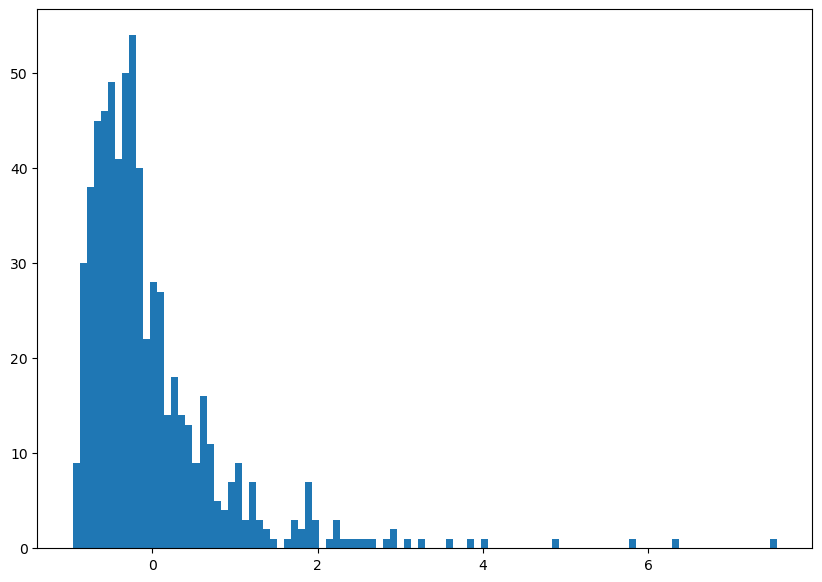

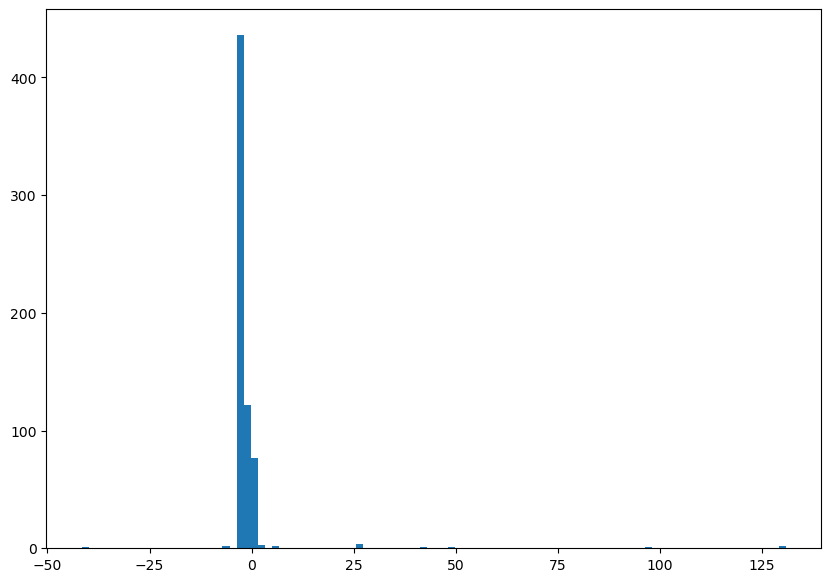

In [149]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds =2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1


r2 = pearsonr(y_true, y_preds)[0]

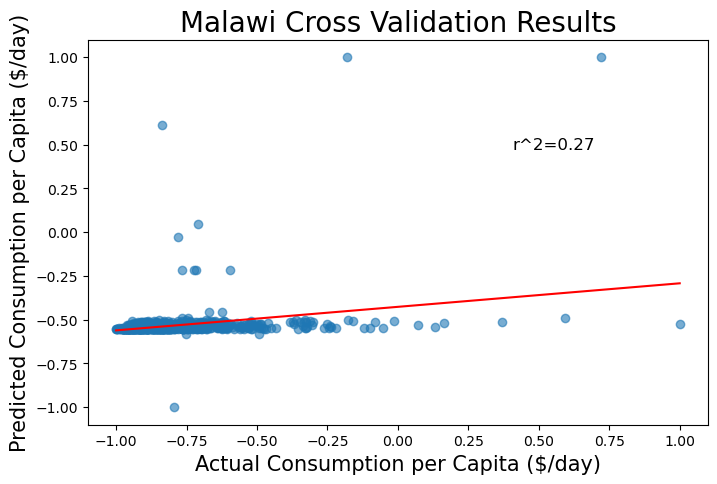

In [150]:
# Plot predictions
country = 'Malawi'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()